## PIMS Hackathon, Seattle 2025
### Project B - Preconditioners for Thermal Radiative Transfer
Packages: jupyter, numpy, matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from library import *

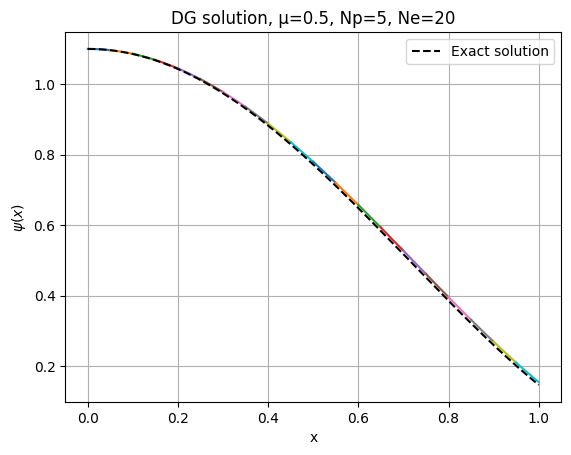

In [3]:
# ─── Example usage ───

# Parameters for the transport problem
μ       = 0.5
σ_t     = lambda x: x**2 + 1
source  = lambda x: (μ**3)*(2*x - 6.8*np.sin(2*x)) + (σ_t(x) * (μ**2)*((x**2 +1) + 3.4*np.cos(2*x)))
inflow  = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))

# Mesh parameters
xs      = np.linspace(0, 1, 21) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)

# Plot numerical solution against the exact solution (MMS)
ψ_MMS     = lambda x: (μ**2)*((x**2 +1) + 3.4*np.cos(2*x))
ψ_weights = transport_direct_solve(μ, σ_t, source, inflow, Np, xs)
plot_solution(ψ_weights, xs, Np, μ=μ, exact_ψ_func=ψ_MMS)

# Spectrum of $(I-T)^{-1}$

## Definitions

$(I-T)^{-1} = \epsilon \alpha F_{||} - \epsilon^2 [ \frac{1}{3} M_{t}^{-1} (G - \frac{1}{2}F) M_{t}^{-1} (G - \frac{1}{2}F) - M_{t}^{-1}M_{a} ] + \mathcal{O}(\epsilon^3)$

$D = \alpha \epsilon^{-1} F_{||} - [ \frac{1}{3} M_{t}^{-1} (G - \frac{1}{2}F) M_{t}^{-1} (G - \frac{1}{2}F) - M_{t}^{-1}M_{a} ]$

$F^+,F^- \leftarrow $ assemble_face_matrices

$F = F^+ + F^-$

$F_{||} = F^+ - F^-$

$G \leftarrow $ assemble_deriv_matrix

$[M_{t/a}]_{mn} = \int_{x_e}^{x_{e+1}} \sigma_{t/a} v_{e,n} v_{e,m} dx$

$ \alpha = \frac{1}{2}\sum_{k} \omega_k |\mu_k| $

$ \epsilon \leftarrow $ from user as a hyperparameter


D shape: (100, 100)
spectral radius of (I - T)^\{-1\} ≈ 0.049014962317737665


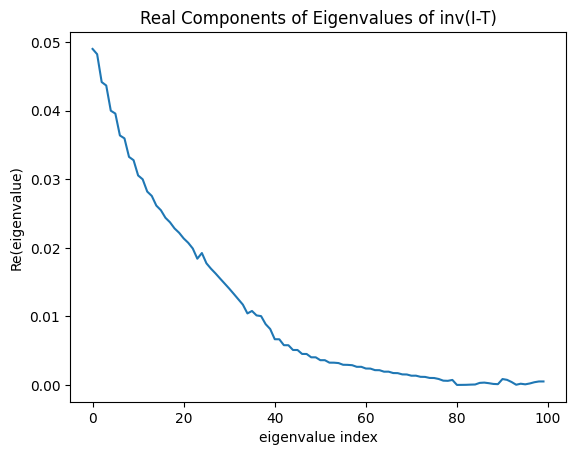

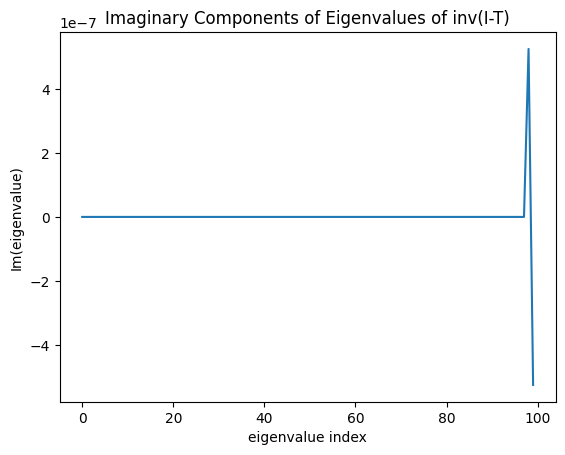

In [11]:
# Parameters for the transport problem
μ       = 0.5
σ_t     = lambda x: x**2 + 1
σ_a     = lambda x: x**2 + 1

# Mesh parameters
xs      = np.linspace(0, 1, 21) # Mesh points / element boundaries
Np      = 5                     # Legendre polynomials per element (basis size)
for_TSA = False

# Set \epsilon hyperparameter
epsilon = 1e-3

# Get F, F_{||} from F^+ and F^- via assemble_face_matrices
F_plus, F_minus = assemble_face_matrices(Np, xs, for_TSA=for_TSA)
F = F_plus + F_minus
F_parallel = F_plus - F_minus

# Get G from assemble_deriv_matrix
G = assemble_deriv_matrix(Np, xs)

# Get M_t/a via sigma_t/a
M_t = assemble_mass_matrix(σ_t, Np, xs)
M_a = assemble_mass_matrix(σ_a, Np, xs)

# Get alpha from omega_k and mu_k
N_mu = 3*Np
mu_k, w_k = gausslegendre(N_mu)
alpha = 0.5 * np.dot(w_k, np.abs(mu_k))

# Precompute M_t_inv and (G - 1/2 F)
M_t_inv = np.linalg.inv(M_t)
G_minus_half_of_F = G - 0.5*F

# Compute D
D_inner = (1.0/3.0) * (M_t_inv @ G_minus_half_of_F @ M_t_inv @ G_minus_half_of_F) - (M_t_inv @ M_a)
D = (alpha/epsilon) * F_parallel - D_inner

# Analyze spectrum of transport operator (I - T)^{-1} via epsilon^2 D
I_minus_T_inv_perturbation = (epsilon**2) * D
print("D shape:", D.shape)
print(r"spectral radius of (I - T)^\{-1\} ≈", max(abs(np.linalg.eigvals(I_minus_T_inv_perturbation))))
eigvals = np.linalg.eigvals(I_minus_T_inv_perturbation)

plt.plot(range(len(eigvals)), np.real(eigvals))
plt.xlabel('eigenvalue index')
plt.ylabel('Re(eigenvalue)')
plt.title('Real Components of Eigenvalues of inv(I-T)')
plt.show()

plt.plot(range(len(eigvals)), np.imag(eigvals))
plt.xlabel('eigenvalue index')
plt.ylabel('Im(eigenvalue)')
plt.title('Imaginary Components of Eigenvalues of inv(I-T)')
plt.show()



# Spectrum of $I-T$


spectral radius of (I - T)^\{-1\} ≈ 357108.56616296404


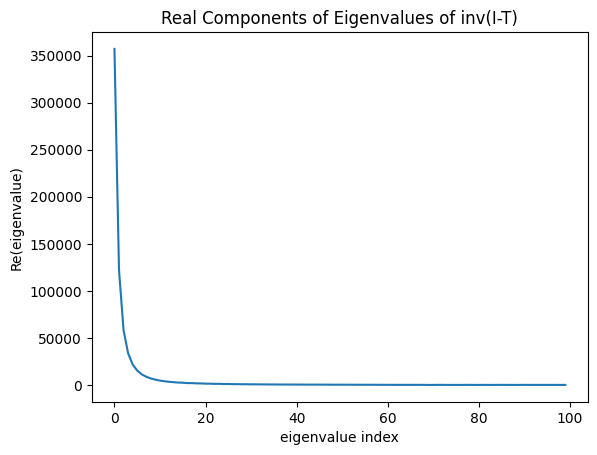

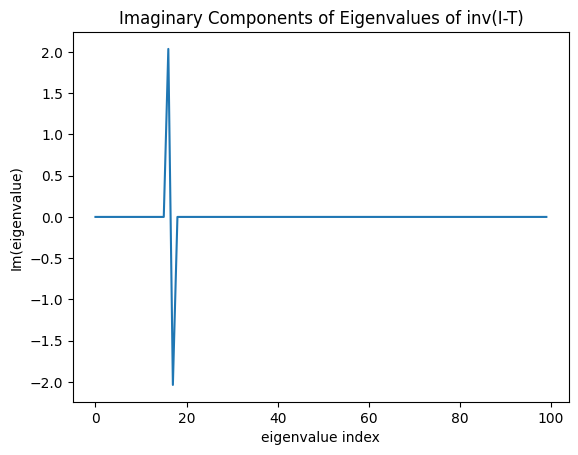

In [ ]:
I_minus_T = np.linalg.inv(I_minus_T_inv_perturbation)
print(r"spectral radius of (I - T)^\{-1\} ≈", max(abs(np.linalg.eigvals(I_minus_T))))

eigvals = np.linalg.eigvals(I_minus_T)

plt.plot(range(len(eigvals)), np.real(eigvals))
plt.xlabel('eigenvalue index')
plt.ylabel('Re(eigenvalue)')
plt.title('Real Components of Eigenvalues of I-T')
plt.show()

plt.plot(range(len(eigvals)), np.imag(eigvals))
plt.xlabel('eigenvalue index')
plt.ylabel('Im(eigenvalue)')
plt.title('Imaginary Components of Eigenvalues of I-T)')
plt.show()

